<a href="https://colab.research.google.com/github/nguyetvo/2019-Kaggle-ML-DS-Survey/blob/master/Exploring_PhD_Community_with_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install jgraph
!pip install kmodes
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
from collections import Counter
import re
import warnings
import itertools
pd.set_option('mode.chained_assignment', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Clustering and networks
import jgraph
import networkx as nx
from networkx.algorithms import community
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from community import community_louvain
from kmodes.kmodes import KModes

# Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

# Confidence interval
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return np.round(m, 2), np.round(m-h), np.round(m+h, 2)


# Colors
COLORS_SET_B_G_R = [sns.color_palette('muted')[0], sns.color_palette('muted')[2], sns.color_palette('muted')[3]]


In [27]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=90cb2a01ff692c17ac24cd6af128d5c64ef737cb2f1357a5b64c040110a3888b
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [0]:
os.environ['KAGGLE_USERNAME'] = "nguyetvo" 
os.environ['KAGGLE_KEY'] = "1f34732ea5c843e829d5230feff0e412" 

In [29]:
!kaggle --version

Kaggle API 1.5.6


In [30]:
!kaggle competitions download -c kaggle-survey-2019

  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 183MB/s]


In [31]:
!unzip multiple_choice_responses.csv.zip

Archive:  multiple_choice_responses.csv.zip
replace multiple_choice_responses.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: multiple_choice_responses.csv  


In [32]:
# Load survey data
survey_schema = pd.read_csv('/content/survey_schema.csv')
df_responses = pd.read_csv('/content/multiple_choice_responses.csv')

# Dataframe with question code and description
qs = df_responses.iloc[0].T.to_frame()
qs.index.name = "name"
qs.columns = ["description"]

# Remove question labels from the dataset
df_responses.drop(0, inplace=True)
df_responses.reset_index(inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (0,3,7,19,34,47,49,50,51,52,53,54,68,81,94,96,109,115,130,139,147,154,167,180,193,206,219,232,245) have mixed types.Specify dtype option on import or set low_memory=False.



In [33]:
survey_schema.head()

,2019 Kaggle Machine Learning and Data Science Survey,Q1,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q2,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q3,Q30,Q31,Q32,Q33,Q34,Q4,Q5,Q6,Q7,Q8,Q9
0,Question:,What is your age (# years)?,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,What is the primary tool that you use at work ...,How long have you been writing code to analyze...,Which of the following integrated development ...,Which of the following hosted notebook product...,What programming languages do you use on a reg...,What programming language would you recommend ...,What is your gender? - Selected Choice,What data visualization libraries or tools do ...,Which types of specialized hardware do you use...,Have you ever used a TPU (tensor processing un...,For how many years have you used machine learn...,Which of the following ML algorithms do you us...,Which categories of ML tools do you use on a r...,Which categories of computer vision methods do...,Which of the following natural language proces...,Which of the following machine learning framew...,Which of the following cloud computing platfor...,In which country do you currently reside?,Which specific cloud computing products do you...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which of the following relational database pro...,What is the highest level of formal education ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...
1,# of Respondents:,19717,12497,12250,16781,16569,15690,15627,14627,14443,14404,14377,19717,14253,14218,14203,14182,14088,13915,5492,3582,13753,7125,19717,7100,7078,7050,7015,6994,19323,19107,14002,13623,13227,9226
2,Who was excluded? (0 = not excluded; 1 = exclu...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,If What is your age (# years)? 0-17 Is Selected,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,If Select the title most similar to your curre...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1


In [34]:
df_responses.head()

name,index,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,...,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
0,1,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"30,000-39,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,2,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,"5,000-7,499","> $100,000 ($USD)",NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,3,83,55-59,Female,-1,Germany,Professional degree,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,4,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"250,000-299,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,"Slack Communities (ods.ai, kagglenoobs, etc)",NaN,NaN,-1,NaN,Coursera,edX,DataCamp,...,-1,NaN,NaN,Azure Machine Learning Studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1
4,5,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"4,000-4,999",$0 (USD),NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,Other,0,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [35]:
Q4_distrib = pd.DataFrame (df_responses['Q4'].value_counts())
Q4_distrib

,Q4
Master’s degree,8549
Bachelor’s degree,5993
Doctoral degree,2767
Some college/university study without earning a bachelor’s degree,837
Professional degree,611
I prefer not to answer,333
No formal education past high school,233


In [0]:
# Create dataframe for visualization of Q4
Q4_distrib = pd.DataFrame (df_responses['Q4'].value_counts())
Q4_distrib.reset_index(inplace=True)
Q4_distrib_grey = Q4_distrib.copy()
Q4_distrib_grey = Q4_distrib_grey.replace(to_replace=2767, value=0)

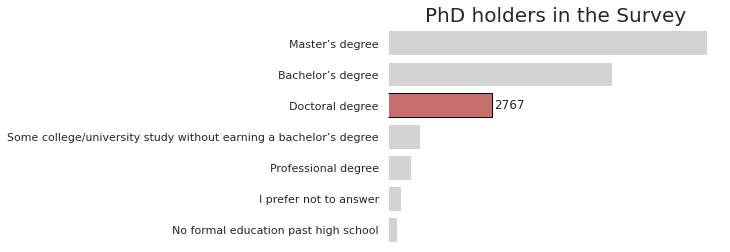

In [37]:
# Visualization of Q4
sns.set(style="whitegrid")
f,ax = plt.subplots(figsize=(6, 4))

# Plot first layer
sns.barplot(x="Q4", y="index", data=Q4_distrib,
            color=COLORS_SET_B_G_R[2], edgecolor='black')
sns.despine(left=True, bottom=True)

# Plot second layer
sns.set(style="whitegrid")
sns.barplot(x="Q4", y="index", data=Q4_distrib_grey,
            color='lightgrey')
sns.despine(left=True, bottom=True)

# Add number of PhD holders
_ = plt.text(2850, 2.1, '2767', fontsize=12)

# Set title
_ = ax.set_title('PhD holders in the Survey', fontsize=20)

# Remove redundant labels and borders
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")

# Options setup
_ = plt.setp(f.patches, linewidth=0.5) 

In [0]:
# Create subsets of variable dedicated to skills, activities, programming languages etc.
ide_usage = ["Q16_Part_1", "Q16_Part_2", "Q16_Part_3", "Q16_Part_4", "Q16_Part_5", "Q16_Part_6", "Q16_Part_7", "Q16_Part_8", "Q16_Part_9", "Q16_Part_10"]
notebook_usage = ["Q17_Part_1", "Q17_Part_2", "Q17_Part_3", "Q17_Part_4", "Q17_Part_5", "Q17_Part_6", "Q17_Part_7", "Q17_Part_8", "Q17_Part_9", "Q17_Part_10"]
language_usage = ["Q18_Part_1", "Q18_Part_2", "Q18_Part_3", "Q18_Part_4", "Q18_Part_5", "Q18_Part_6", "Q18_Part_7", "Q18_Part_8", "Q18_Part_9", "Q18_Part_10"]
visual_usage = ["Q20_Part_1", "Q20_Part_2", "Q20_Part_3", "Q20_Part_4", "Q20_Part_5", "Q20_Part_6", "Q20_Part_7", "Q20_Part_8", "Q20_Part_9", "Q20_Part_10"]
algo_usage = ["Q24_Part_1", "Q24_Part_2", "Q24_Part_3", "Q24_Part_4", "Q24_Part_5", "Q24_Part_6", "Q24_Part_7", "Q24_Part_8", "Q24_Part_9", "Q24_Part_10"]
ml_tools_usage = ["Q25_Part_1", "Q25_Part_2", "Q25_Part_3", "Q25_Part_4", "Q25_Part_5", "Q25_Part_6"]
cv_usage = ["Q26_Part_1", "Q26_Part_2", "Q26_Part_3", "Q26_Part_4", "Q26_Part_5"]
nlp_usage = ["Q27_Part_1", "Q27_Part_2", "Q27_Part_3", "Q27_Part_4"]
ml_frameworks_usage = ["Q28_Part_1", "Q28_Part_2", "Q28_Part_3", "Q28_Part_4", "Q28_Part_5", "Q28_Part_6", "Q28_Part_7", "Q28_Part_8", "Q28_Part_9", "Q28_Part_10"]
cloud_platforms_usage = ["Q29_Part_1", "Q29_Part_2", "Q29_Part_3", "Q29_Part_4", "Q29_Part_5", "Q29_Part_6", "Q29_Part_7", "Q29_Part_8", "Q29_Part_9", "Q29_Part_10"]
cloud_products_usage = ["Q30_Part_1", "Q30_Part_2", "Q30_Part_3", "Q30_Part_4", "Q30_Part_5", "Q30_Part_6", "Q30_Part_7", "Q30_Part_8", "Q30_Part_9", "Q30_Part_10"]
big_data_products_usage = ["Q31_Part_1", "Q31_Part_2", "Q31_Part_3", "Q31_Part_4", "Q31_Part_5", "Q31_Part_6", "Q31_Part_7", "Q31_Part_8", "Q31_Part_9", "Q31_Part_10"]
ml_products_usage = ["Q32_Part_1", "Q32_Part_2", "Q32_Part_3", "Q32_Part_4", "Q32_Part_5", "Q32_Part_6", "Q32_Part_7", "Q32_Part_8", "Q32_Part_9", "Q32_Part_10"]
automl_tools = ["Q33_Part_1", "Q33_Part_2", "Q33_Part_3", "Q33_Part_4", "Q33_Part_5", "Q33_Part_6", "Q33_Part_7", "Q33_Part_8", "Q33_Part_9", "Q33_Part_10"]
db_tools = ["Q34_Part_1", "Q34_Part_2", "Q34_Part_3", "Q34_Part_4", "Q34_Part_5", "Q34_Part_6", "Q34_Part_7", "Q34_Part_8", "Q34_Part_9", "Q34_Part_10"]

# Get separate dataframe with skills related questions
skills_questions = [ide_usage, notebook_usage, language_usage, visual_usage, algo_usage,
                    ml_tools_usage, cv_usage, nlp_usage, ml_frameworks_usage, cloud_platforms_usage, big_data_products_usage,
                   ml_products_usage, automl_tools, db_tools]
skills_questions = np.concatenate(skills_questions)
df_skills = df_responses[skills_questions]

# Recode to binary
df_skills[~df_skills.isnull()] = 1
df_skills[df_skills.isnull()] = 0

# Remove participant who did not mentioned any skills
df_skills = df_skills[df_skills.sum(1) > 0]

# Get proper labels for skills
labels = pd.DataFrame(df_skills.columns).merge(qs, left_on='name', right_on='name')
# Preprocess lables
labels['description'] = labels['description'].apply(lambda string: string.strip())
def fixMatlab(string):
    if 'MATLAB' in string:
        if 'IDE' in string:
            string = string + ' IDE'
        else:
            string = string + ' language'
    return string
labels['description'] = labels['description'].apply(fixMatlab)
labels['description'] = labels['description'].apply(
    lambda d: re.sub("[\(\[].*?[\)\]]", "", d.split('Selected Choice - ')[-1]).strip())
df_skills.columns = labels['description']

# Remove rare skills
SELECTED_SKILLS = df_skills.sum(0).sort_values(ascending=False)[df_skills.sum(0) > 500].index
df_skills = df_skills.loc[:,SELECTED_SKILLS]
# Remove participant who did not mentioned any skills
df_skills = df_skills[df_skills.sum(1) > 0]

# Create final dataframe with socio-demographic parameters and skills
df_socdem = df_responses.loc[:,['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q10', 'Q15', 'Q23']]
df_fin = df_socdem.merge(df_skills, left_index=True, right_index=True)

# Change names of countries
df_fin['Q3'] = df_fin['Q3'].replace({'Iran, Islamic Republic of...':'Iran',
                                     'Republic of Korea':'South Korea',
                                     'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
                                     'United States of America':'USA'})

# Drop respondents who did't indicate their country
df_fin = df_fin.dropna(subset=['Q3'])

# PhD or Not PhD
df_fin['Q4_phd'] = list(map(lambda e: 'PhD' if e == 'Doctoral degree' else 'not PhD', df_fin['Q4']))
df_fin['Q4_phd'] = df_fin['Q4_phd'].astype('category')

# Student or Not Student
df_fin['student'] = ['Student' if p == 'Student' else 'Not Student' for p in df_fin['Q5']]
df_fin['student'] = df_fin['student'].astype('category')

# Salary to ordinal
df_fin['Q10'] = df_fin['Q10'].astype('category')
df_fin['Q10'].cat.reorder_categories(["$0-999", "1,000-1,999", "2,000-2,999", "3,000-3,999", "4,000-4,999",
                                      "5,000-7,499", "7,500-9,999", "10,000-14,999", "15,000-19,999",
                                      "20,000-24,999", "25,000-29,999", "30,000-39,999", "40,000-49,999",
                                      "50,000-59,999", "60,000-69,999", "70,000-79,999", "80,000-89,999",
                                      "90,000-99,999", "100,000-124,999", "125,000-149,999", "150,000-199,999",
                                      "200,000-249,999", "250,000-299,999", "300,000-500,000", "> $500,000"]
                                      , inplace=True)

# Experience to ordinal
df_fin['Q15'] = df_fin['Q15'].astype('category')
df_fin['Q15'].cat.reorder_categories(['< 1 years', '1-2 years', '3-5 years', '5-10 years', '10-20 years', '20+ years']
                                      , inplace=True)

# Age to ordinal
df_fin['Q1'] = df_fin['Q1'].astype('category')
df_fin['Q1'].cat.reorder_categories(['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70+'], inplace=True)

# Varible with Top 20 countries
top_countries = list(df_fin.Q3.value_counts().head(21).index)
top_countries.remove('Other')
df_fin['Q3_top'] = list(map(lambda c: c if c in top_countries else np.nan, df_fin['Q3']))

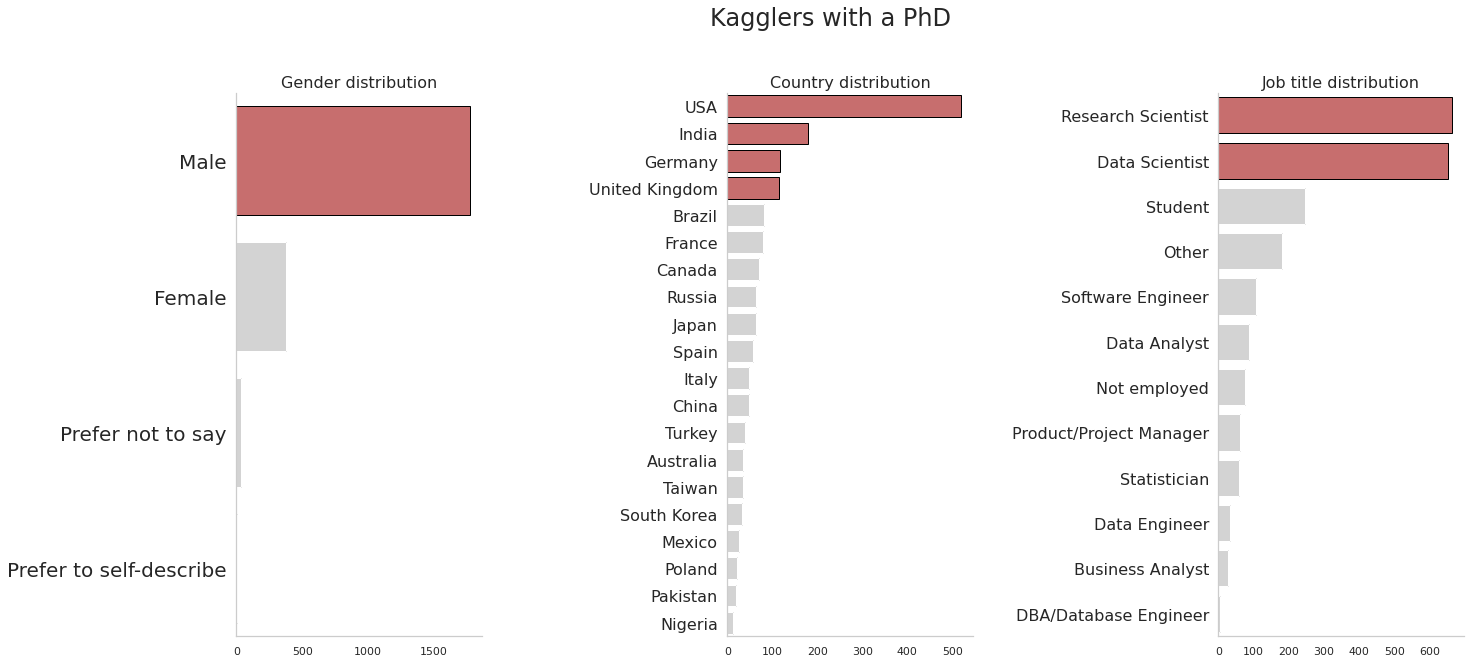

In [42]:
# Create dataframe for visualization of Q4
df_phd_viz = df_fin[df_fin['Q4_phd'] == 'PhD']
df_phd_viz_country = pd.DataFrame(df_phd_viz['Q3_top'].value_counts())
df_phd_viz_country.reset_index(inplace=True)
df_phd_viz_country_grey = df_phd_viz_country.copy()
df_phd_viz_country_grey['Q3_top'] = [0] * 4 + list(df_phd_viz_country_grey['Q3_top'])[4:]

# Create dataframe for visualization of Q5
df_phd_viz_role = pd.DataFrame(df_phd_viz['Q5'].value_counts())
df_phd_viz_role.reset_index(inplace=True)
df_phd_viz_role_grey = df_phd_viz_role.copy()
df_phd_viz_role_grey['Q5'] = [0] * 2 + list(df_phd_viz_role_grey['Q5'])[2:]

# Create dataframe for visualization of Q2
df_phd_viz_gender = pd.DataFrame(df_phd_viz['Q2'].value_counts())
df_phd_viz_gender.reset_index(inplace=True)
df_phd_viz_gender_grey = df_phd_viz_gender.copy()
df_phd_viz_gender_grey['Q2'] = [0] + list(df_phd_viz_gender_grey['Q2'])[1:]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 10))
# Plot first layer
sns.barplot(x="Q2", y="index", data=df_phd_viz_gender,
            label="Total",ax=axes[0], color=COLORS_SET_B_G_R[2], edgecolor='black')
# Plot second layer
sns.barplot(x="Q2", y="index", data=df_phd_viz_gender_grey,
            label="Total",ax=axes[0], color='lightgrey')

# Remove redundant labels and borders
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")

# Set title
_ = axes[0].set_title('Gender distribution', fontsize=16)

# Set xticks labels
axes[0].tick_params(axis='y', which='major', labelsize=20)

# Plot first layer
sns.barplot(x="Q3_top", y="index", data=df_phd_viz_country,
            label="Total", ax=axes[1], color=COLORS_SET_B_G_R[2], edgecolor='black')
# Plot second layer
sns.barplot(x="Q3_top", y="index", data=df_phd_viz_country_grey,
            label="Total",ax=axes[1], color='lightgrey')
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
_ = axes[1].set_title('Country distribution', fontsize=16)
axes[1].tick_params(axis='y', which='major', labelsize=16)

# Plot first layer
sns.barplot(x="Q5", y="index", data=df_phd_viz_role,
            label="Total", ax=axes[2], color=COLORS_SET_B_G_R[2], edgecolor='black')
# Plot second layer
sns.barplot(x="Q5", y="index", data=df_phd_viz_role_grey,
            label="Total",ax=axes[2], color='lightgrey')
axes[2].xaxis.grid(False)
axes[2].yaxis.grid(False)
axes[2].xaxis.set_label_text("")
axes[2].yaxis.set_label_text("")
_ = axes[2].set_title('Job title distribution', fontsize=16)
axes[2].tick_params(axis='y', which='major', labelsize=16)
sns.despine(left=False, bottom=False)

# Add title
st = fig.suptitle("Kagglers with a PhD", fontsize=24, x =0.5, y=1)

# Additional setup
fig.subplots_adjust(wspace=1)
_ = plt.setp(fig.patches, linewidth=0.5)

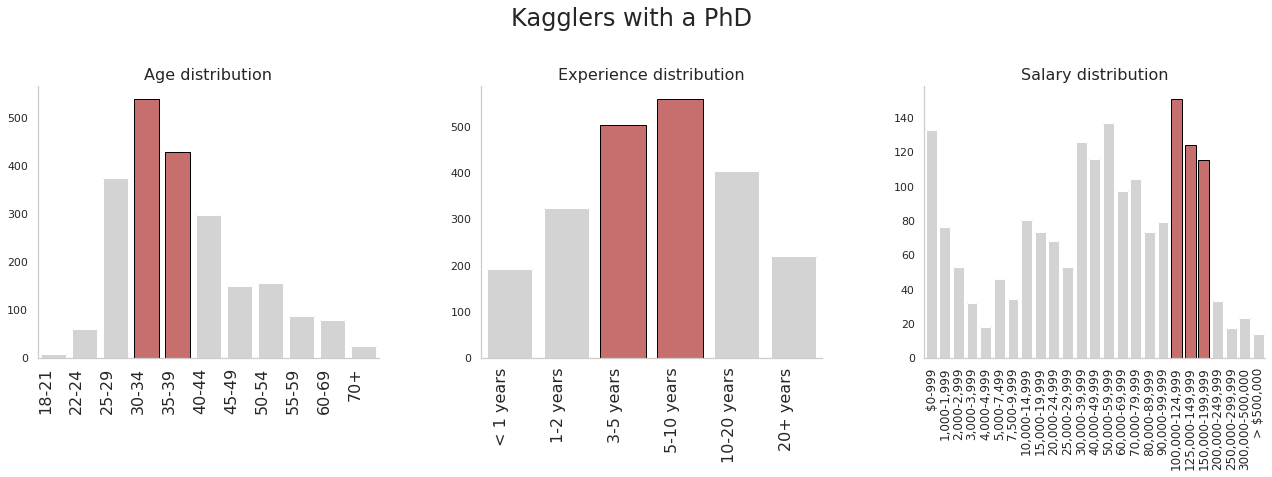

In [43]:
# Create dataframe for visualization of Q1
df_phd_viz_age = df_phd_viz.copy()
df_phd_viz_age = df_phd_viz_age.query("Q1 != '30-34' and Q1 != '35-39'")

# Create dataframe for visualization of Q15
df_phd_viz_exp = df_phd_viz.copy()
df_phd_viz_exp = df_phd_viz_exp.query("Q15 != '3-5 years' and Q15 != '5-10 years'")

# Create dataframe for visualization of Q10
df_phd_viz_salary = df_phd_viz.copy()
df_phd_viz_salary = df_phd_viz_salary.query("Q10 != '100,000-124,999' and Q10 != '125,000-149,999' and Q10 != '150,000-199,999'")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
# Plot first layer
g = sns.countplot(x="Q1", color=COLORS_SET_B_G_R[2], data=df_phd_viz, ax=axes[0], edgecolor='black')
g = g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment="right")
# Plot second layer
g = sns.countplot(x="Q1", color="lightgrey", data=df_phd_viz_age, ax=axes[0])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment="right")
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")
_ = axes[0].set_title('Age distribution', fontsize=16)
axes[0].tick_params(axis='x', which='major', labelsize=16)

# Plot first layer
g = sns.countplot(x="Q15", color=COLORS_SET_B_G_R[2], data=df_phd_viz, ax=axes[1], edgecolor='black')
g = g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment="right")
# Plot second layer
g = sns.countplot(x="Q15", color="lightgrey", data=df_phd_viz_exp, ax=axes[1])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment="right")
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
_ = axes[1].set_title('Experience distribution', fontsize=16)
axes[1].tick_params(axis='x', which='major', labelsize=16)

# Plot first layer
g = sns.countplot(x="Q10", color=COLORS_SET_B_G_R[2], data=df_phd_viz, ax=axes[2], edgecolor='black')
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)
# Plot second layer
g = sns.countplot(x="Q10", color="lightgrey", data=df_phd_viz_salary, ax=axes[2])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)
axes[2].xaxis.grid(False)
axes[2].yaxis.grid(False)
axes[2].xaxis.set_label_text("")
axes[2].yaxis.set_label_text("")
_ = axes[2].set_title('Salary distribution', fontsize=16)
axes[2].tick_params(axis='x', which='major', labelsize=12)

# Add title
st = fig.suptitle("Kagglers with a PhD", fontsize=24, x =0.5, y=1.1)

# Additional setup
sns.despine(left=False, bottom=False)
fig.subplots_adjust(wspace=0.3)
_ = plt.setp(fig.patches, linewidth=0.5)

In [61]:
!pip3 install python-igraph
from igraph import *

In [0]:
def participantsGraphObj(df, q_threshold=0.95, SELECTED_SKILLS=SELECTED_SKILLS, only_phd=True, removeDisconnected=True):
    
    # Select only PhD participants
    if only_phd:
        df = df.query("Q4 == 'Doctoral degree'")
    df.reset_index(inplace=True, drop=True)
    # Create similarity matrix
    similarity_matrix = cosine_similarity(df.loc[:,SELECTED_SKILLS])
    threshold = np.quantile(np.concatenate(similarity_matrix), q_threshold)
    # threshold = np.median(np.concatenate(similarity_matrix))
    similarity_matrix[similarity_matrix < threshold] = 0
    similarity_matrix[similarity_matrix >= threshold] = 1
    np.fill_diagonal(similarity_matrix, 0)
    # Create Graph structure
    G = igraph.Graph.Adjacency((similarity_matrix > 0).tolist())
    G.to_undirected()
    G.simplify()
    # Add vertex objects and connected indicator to intial dataframe
    df['vertex'] = list(G.vs)
    df['connected'] = pd.Series(G.components().membership) == 0
    if removeDisconnected:
        df = df[df['connected'] == True]
        G = G.induced_subgraph(list(df['vertex']))
        
    return df, G, similarity_matrix

df_phd, G, similarity_matrix = participantsGraphObj(df_fin, q_threshold=0.99)

# Community detection
fg = G.community_fastgreedy()
fg = fg.as_clustering()

# Add community label to the dataframe
df_phd['community'] = fg.membership

# Select only large communities
df_phd['community'] = [com if com <= 2  else np.nan for com in df_phd['community']]

# Creating layout
layout = G.layout("lgl")

# Rename communities according to the skills of participants
community_name_dict = {0:'Python and Deep Learning', 1:'R and Classical ML', 2:'Python and Classical ML'}
df_phd['community'] = df_phd['community'].map(community_name_dict)
df_phd['community'] = df_phd['community'].astype('category')

# Recode degree to binary
degree_list = list(G.degree())
modifed_degree_list = list(map(lambda x: 10 if x >= np.quantile(degree_list, 0.95) else 5, degree_list))
df_phd['degree'] = list(G.degree())
G.vs['size'] = modifed_degree_list

# Get appropriate colors for communities
community_colors = pd.Series(fg.membership).map({0:COLORS_SET_B_G_R[0],
                                                 1:COLORS_SET_B_G_R[1],
                                                 2:COLORS_SET_B_G_R[2]})
community_colors = list(community_colors.fillna('lightgrey'))

# To plot the bellow Graph without Text you need to execute following line:
# igraph.plot(G, layout=layout, edge_width=0.2, vertex_frame_width=0.5, vertex_color=community_colors, bbox=(800, 800))

# igraph doesnt support addition of titles or legend

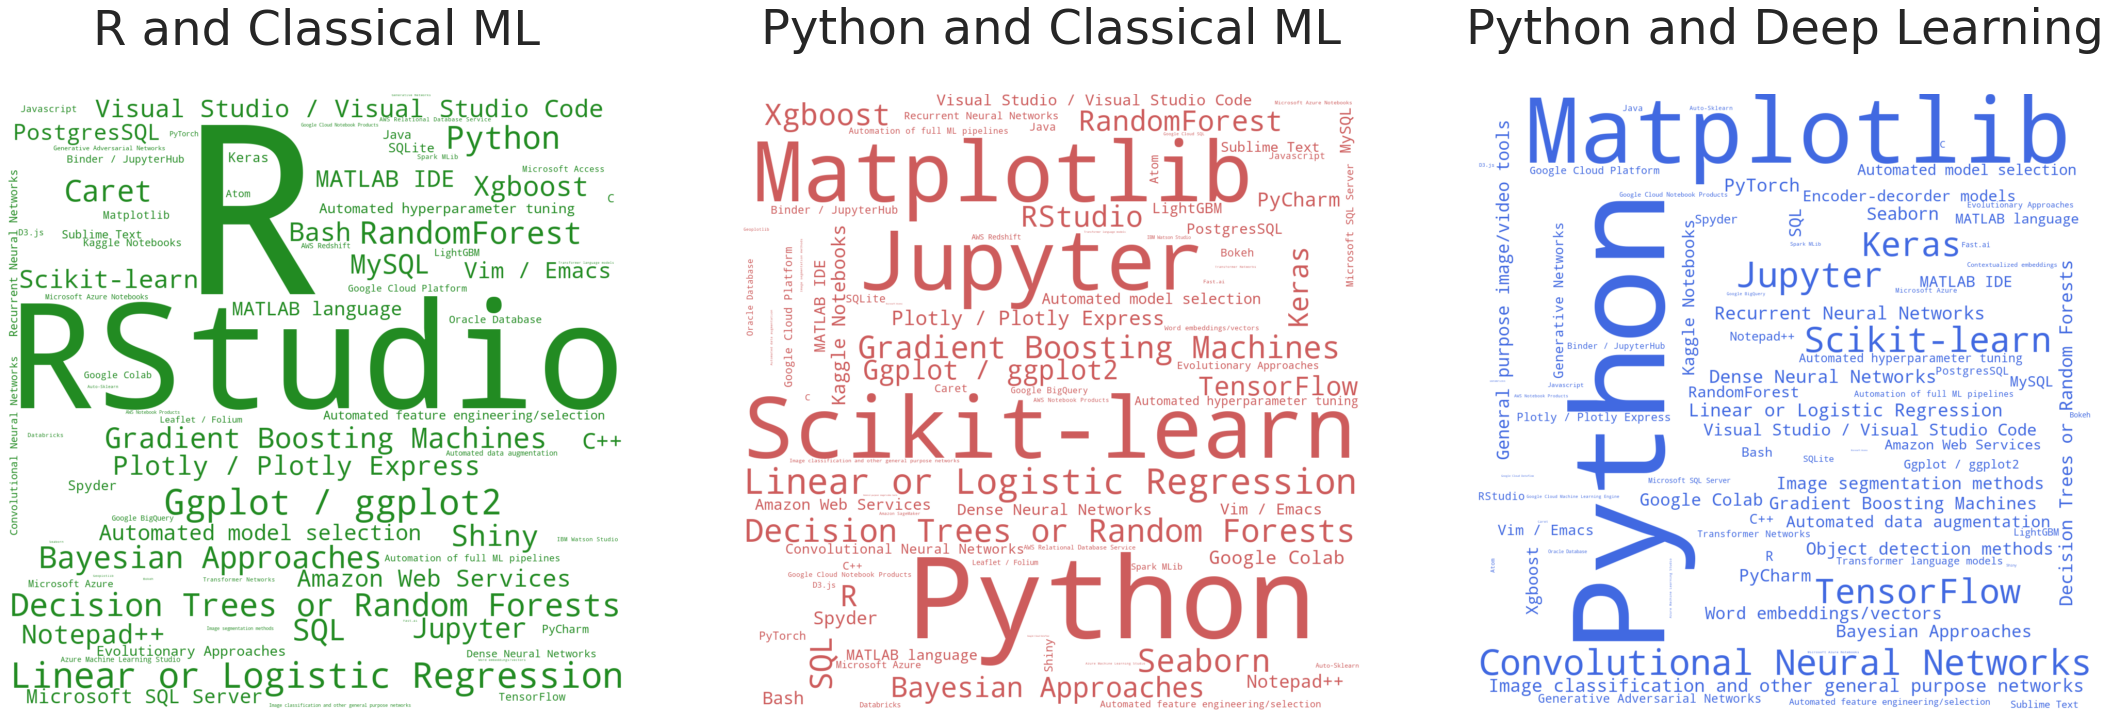

In [60]:
# Skills in each community
community_skills = pd.DataFrame({'R and Classical ML':df_phd[df_phd['community'] == 'R and Classical ML'].loc[:,SELECTED_SKILLS].sum(),
                                 'Python and Classical ML':df_phd[df_phd['community'] == 'Python and Classical ML'].loc[:,SELECTED_SKILLS].sum(),
                                 'Python and Deep Learning':df_phd[df_phd['community'] == 'Python and Deep Learning'].loc[:,SELECTED_SKILLS].sum()})

fig = plt.figure()
fig.set_size_inches(30, 10)

# Set of colors
colors_set = ['forestgreen', 'indianred', 'royalblue']
for i in range(community_skills.shape[1]):
    
    # Generate string with proportional words 
    top_skills = community_skills[community_skills.columns[i]].sort_values(ascending=True)
    top_skills = top_skills.rank()
    skills_string = []
    for skill_i in range(len(top_skills)):
        skills_string.extend([top_skills.index[skill_i]] * int(top_skills.values[skill_i]))
    ax = fig.add_subplot(1,3,i+1)
    word_could_dict=Counter(skills_string)
    # Create wordcloud object
    wordcloud = WordCloud(width = 1200, height = 1200, background_color="white",
                          color_func=lambda *args, **kwargs: colors_set[i], relative_scaling = 1).generate_from_frequencies(word_could_dict)
    

    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')
    ax.set_title(community_skills.columns[i], size=48, pad=50)
    
plt.tight_layout(pad=0)
plt.show()

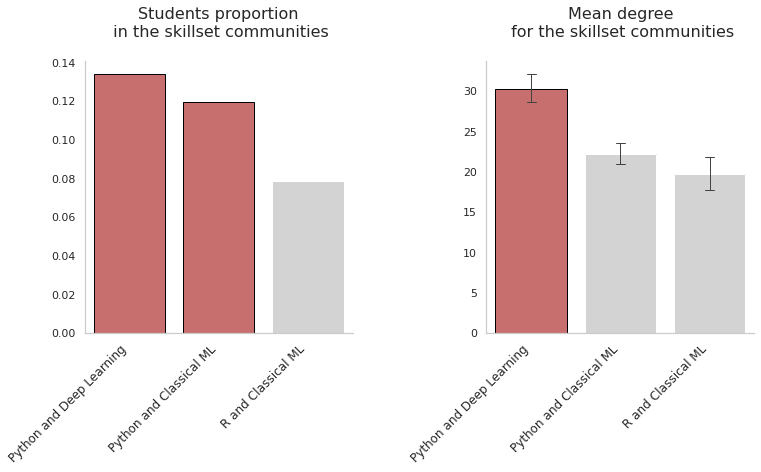

In [63]:
# Create dataframe for visualization
communties_students = pd.crosstab(df_phd['community'], df_phd['student'], normalize='index')
communties_students = pd.DataFrame(communties_students['Student'].sort_values(ascending=False))
communties_students.reset_index(inplace=True)
communties_students['community'] = communties_students['community'].astype('category')
communties_students['community'].cat.reorder_categories(['Python and Deep Learning', 'Python and Classical ML', 'R and Classical ML']
                                      , inplace=True)
communties_students_viz = communties_students.copy()
communties_students_viz['Student'] = list(communties_students_viz['Student'])[:2] + [0]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.set(style="whitegrid")
# First layer
sns.barplot(x="community", y="Student", data=communties_students,
            label="Total", color='lightgrey', ax=axes[0])
# Second layer
sns.barplot(x="community", y="Student", data=communties_students_viz,
            label="Total", color=COLORS_SET_B_G_R[2], ax=axes[0], edgecolor='black')

# Remove redundant borders
sns.despine(left=False, bottom=False)
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")
# Set title
_ = axes[0].set_title('Students proportion\n in the skillset communities', fontsize=16, pad=25)
# Set x ticks
axes[0].tick_params(axis='x', which='major', labelsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Create dataframe for visualization
df_phd_viz_degree_com = df_phd.copy()
df_phd_viz_degree_com = df_phd_viz_degree_com.query("community != 'Python and Classical ML'")
# First layer
g = sns.barplot(x="community", y="degree",
                data=df_phd, color=COLORS_SET_B_G_R[2],
                dodge=True, ci=90, capsize=0.1, errwidth =1, ax=axes[1], edgecolor='black')
# Second layer
g = sns.barplot(x="community", y="degree",
                data=df_phd_viz_degree_com, color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[1])
# Remove redundant borders
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
sns.despine(left=False, bottom=False)
# Set tile
_ = axes[1].set_title('Mean degree\n for the skillset communities', fontsize=16, pad=25)
axes[1].tick_params(axis='x', which='major', labelsize=12)
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')

# Additional options
fig.subplots_adjust(wspace=0.5)
_ = plt.setp(fig.patches, linewidth=0.5)

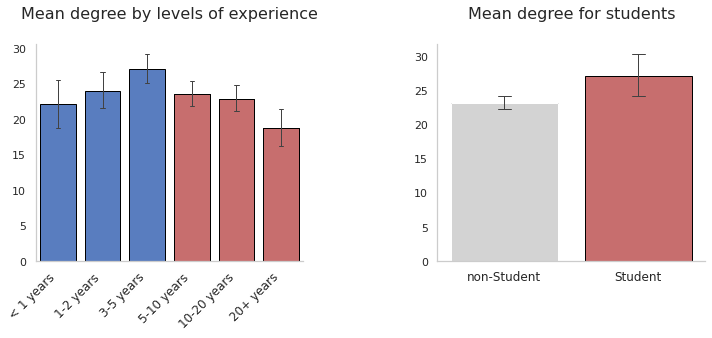

In [64]:
# Create dataframes for visualization
df_phd_viz_degree_exp = df_phd.copy()
df_phd_viz_degree_exp = df_phd_viz_degree_exp.query("Q15 != '< 1 years' and Q15 != '1-2 years' and Q15 != '3-5 years'")
df_phd_viz_degree_student = df_phd.copy()
df_phd_viz_degree_student = df_phd_viz_degree_student.query("student != 'Student'")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.set(font_scale=1, style="whitegrid")

# First layer
g = sns.barplot(x="Q15", y="degree",
                data=df_phd, color=COLORS_SET_B_G_R[0],
                dodge=True, ci=90, capsize=0.1, ax=axes[0], errwidth =1, edgecolor='black')
# Second layer
g = sns.barplot(x="Q15", y="degree",
                data=df_phd_viz_degree_exp, color=COLORS_SET_B_G_R[2],
                dodge=True, ci=None, capsize=0.1, ax=axes[0], edgecolor='black')
# Remove redundant labels and borders
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")
sns.despine(left=False, bottom=False)
# Set title
_ = axes[0].set_title('Mean degree by levels of experience', fontsize=16, pad=25)
# Set x ticks
axes[0].tick_params(axis='x', which='major', labelsize=12)

g = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

# First layer
g = sns.barplot(x="student", y="degree",
                data=df_phd, color=COLORS_SET_B_G_R[2],
                dodge=True, ci=90, capsize=0.1, ax=axes[1], errwidth =1, edgecolor='black')
# Second layer
g = sns.barplot(x="student", y="degree",
                data=df_phd_viz_degree_student, color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[1])
# Remove redundant labels and borders
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
sns.despine(left=False, bottom=False)
# Set title
_ = axes[1].set_title('Mean degree for students', fontsize=16, pad=25)
# Set x ticks params
axes[1].tick_params(axis='x', which='major', labelsize=12)
_ = axes[1].xaxis.set_ticklabels(["non-Student", "Student"])

# Additional options
fig.subplots_adjust(wspace=0.5)
_ = plt.setp(fig.patches, linewidth=0.5)

In [0]:
# Create list of top 20 countries in survey
top_countries = list(df_fin.Q3.value_counts().head(21).index)
top_countries.remove('Other')
# Create dataframe with only these countries
df_fin['Q3_top'] = list(map(lambda c: c if c in top_countries else np.nan, df_fin['Q3']))
top_countries = df_fin['Q3_top'].value_counts().index
df_top15 = df_fin[df_fin['Q3'].apply(lambda country: True if country in top_countries else False)]

# Get matrix of skill similarities between respondents from Top 20 countries
df_phd_temp, G, similarity_matrix = participantsGraphObj(df_top15, q_threshold=0.95, removeDisconnected=False,
                                                    only_phd=False)
similarity_matrix = pd.DataFrame(similarity_matrix)

# Get list of countries coresponding to each respondent
vertex_category = list(df_phd_temp['Q3_top'])


def proportionCategories(column):
    '''Calculate average proportion of connections from each country for one respondent'''
    temp_df = pd.DataFrame({'title':vertex_category,
                            'weight':column})
    return list(temp_df.groupby('title')['weight'].mean())

# Calculate dataframe of respondents and similarity for each countries
df_stats = pd.DataFrame({'vertex_category':vertex_category,
                         'edges_proportion':similarity_matrix.apply(proportionCategories)})
df_stats = pd.concat([df_stats, pd.DataFrame(df_stats.edges_proportion.values.tolist())], 1)
df_stats.drop(columns='edges_proportion', inplace=True)
df_stats.columns = ['vertex_category'] + list(np.sort(df_stats.vertex_category.unique()))

# Grouping respondents from previous dataframe by their countries to obtain matrix of similarities between each country
similarity_stats = df_stats.groupby('vertex_category')[df_stats.columns[1:]].mean()
similarity_stats = (similarity_stats > np.mean(similarity_stats).mean()) + 0

# Load graph from similarity matrix
G = nx.from_numpy_matrix(np.matrix(similarity_stats))

# Remove selfloops
G.remove_edges_from(nx.selfloop_edges(G))

# Add weight to edges
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
weights = [w for w in weights]

# Create kamada-kawai layout
pos_kkl = nx.kamada_kawai_layout(G)


labels = {}
for i, label in enumerate(similarity_stats.columns):
    labels[i] = label
        
# Community detection
partition = list(community.greedy_modularity_communities(G, weight='weight'))
dict_node_community = dict()
for community_i in range(len(partition)):
    for node in partition[community_i]:
        dict_node_community[node] = community_i
partition = pd.DataFrame(pd.Series(dict_node_community)).reset_index().sort_values(by='index')[0].values

# Coloring
community_colors = dict({0:COLORS_SET_B_G_R[0], 1:COLORS_SET_B_G_R[1], 2:COLORS_SET_B_G_R[2], 3:'lightgrey'})
community_colors = list(map(lambda p: community_colors[p], partition))
countries_size = []
for country in similarity_stats.columns:
    countries_size.append(sum(df_phd_temp['Q3_top'] == country))


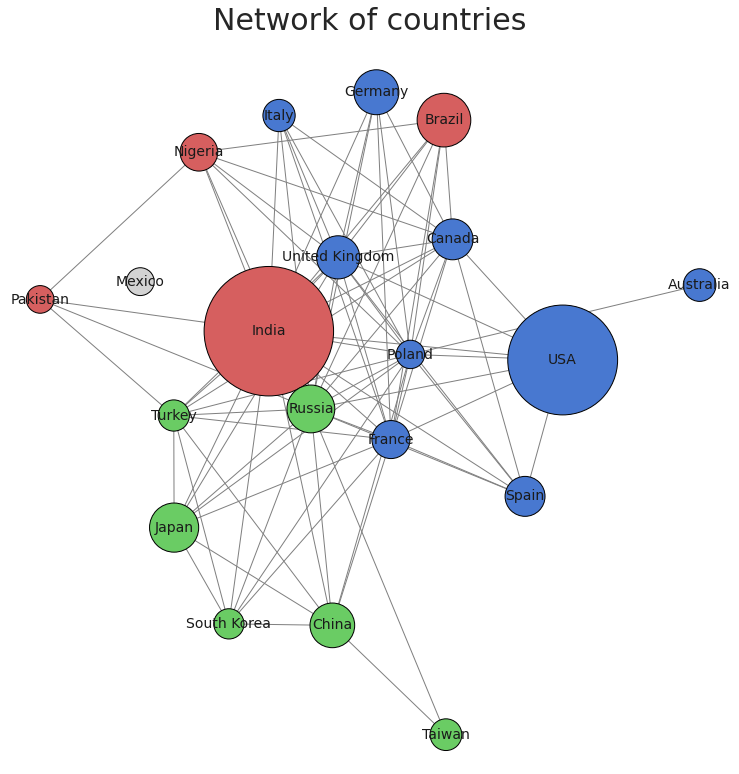

In [66]:
# Plotting the Graph
fig, ax = plt.subplots(figsize=(13, 13))
nx.draw(G, pos_kkl, node_size=list(pd.Series(countries_size)*5),
        edges=edges, width=weights, edge_color='grey', node_color=community_colors)
node_labels = nx.draw_networkx_labels(G, pos_kkl, labels, font_size=14)

# Set the title
_ = ax.set_title('Network of countries', fontsize=30, pad=30)
# Set edge color
plt.gca().collections[0].set_edgecolor("#000000")

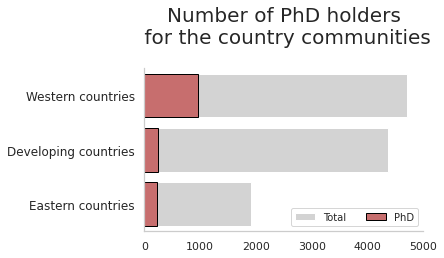

In [67]:
# Create dataframe with countries network statistics
country_network_stats = pd.DataFrame({'country':similarity_stats.columns,
                                      'community':partition})

# Drop Mexico
country_network_stats = country_network_stats[country_network_stats['community'] <= 2]
# Rename them
country_network_stats['community'] = country_network_stats['community'].map({0:'Western countries', 1:'Eastern countries', 2:'Developing countries'})
# Create dictionary with country and community
country_community_dict = dict(zip(country_network_stats['country'], country_network_stats['community']))

# Add countries community to dataframe with PhD participants
df_phd['country_community'] = [country_community_dict[country] if country in country_community_dict else np.nan for country in df_phd['Q3']]

# Add countries community to the full dataframe
df_fin['country_community'] = [country_community_dict[country] if country in country_community_dict else np.nan for country in df_fin['Q3']]

# Number of PhD in each country
stats_phd_total = pd.DataFrame({'PhD':df_phd['country_community'].value_counts(),
                                'Total':df_fin['country_community'].value_counts()})
stats_phd_total.reset_index(inplace=True)

sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5, 3))
sns.barplot(x="Total", y="index", data=stats_phd_total,
            label="Total", color="lightgrey")
sns.barplot(x="PhD", y="index", data=stats_phd_total,
            label="PhD", color=COLORS_SET_B_G_R[2], edgecolor='black')
# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True, prop={'size': 10})
ax.set(xlim=(0, 5000), ylabel="", xlabel="PhD and Total")

# Remove reduntant borders and labels
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")
sns.despine(left=False, bottom=False)

# Set title and labels size
_ = ax.set_title('Number of PhD holders\n for the country communities', fontsize=20, pad=25)
ax.tick_params(axis='y', which='major', labelsize=12)
_ = plt.setp(fig.patches, linewidth=0.5)

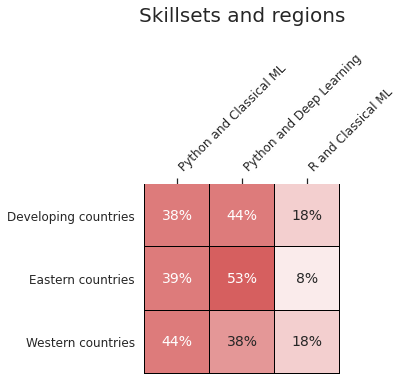

In [68]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.heatmap(pd.crosstab(df_phd['country_community'], df_phd['community'], normalize='index'),
            annot=True, fmt='.0%', linecolor ='black',linewidths=.01, cmap=ListedColormap(sns.light_palette(COLORS_SET_B_G_R[2]).as_hex()),
            cbar=False, annot_kws={"size": 14}, robust=True, vmin=0.05, vmax=0.55)

# Set title
ax.set_title('Eastern-Western difference')

# Set x ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.tick_top()
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='left')

# Remove reduntant labels
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")

# Set title
_ = ax.set_title('Skillsets and regions', fontsize=20, pad=30)

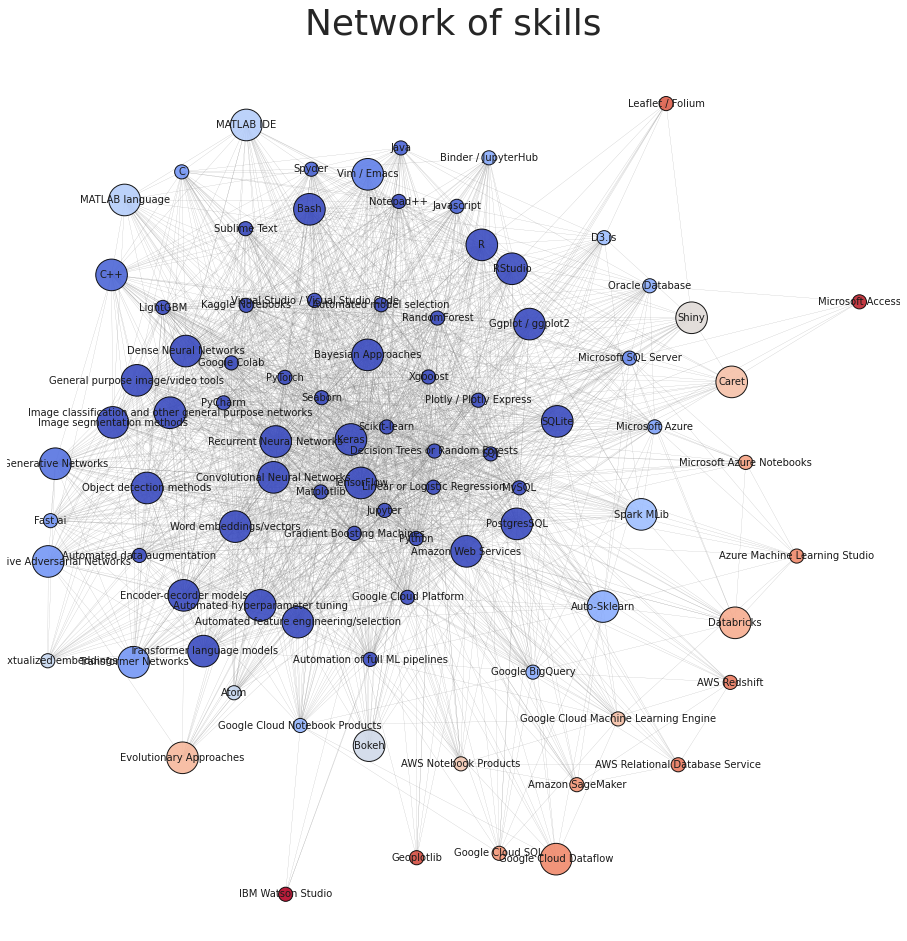

In [69]:
def createSkillsNetwork(df, countries=False):
    
    # Select subset of countries
    if countries:
        df = df[df['country_community'] == countries]
    
    # Creating similarity matrix
    similarity_matrix = cosine_similarity(df.loc[:,SELECTED_SKILLS].T)
    np.fill_diagonal(similarity_matrix, 0)
    # Transform weighted network to binary via threshold
    threshold = np.median(similarity_matrix)
    similarity_matrix[similarity_matrix < threshold] = 0
    similarity_matrix[similarity_matrix >= threshold] = 1
    # Create Graph structure
    G = nx.from_numpy_matrix(similarity_matrix)
    G.remove_edges_from(nx.selfloop_edges(G))
    # Set weights for edges
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights = [w*0.25 for w in weights]
    # Set node sizes
    node_sizes = df.loc[:,SELECTED_SKILLS].sum().values / 10
    
    # Add labels
    labels = {}
    for i, label in enumerate(df.loc[:,SELECTED_SKILLS].columns):
        labels[i] = label
    # Total skills frequency
    total_skills_freq = df.loc[:,SELECTED_SKILLS].sum()
    # Proportion of PhDs per skill
    phd_skills_freq = df[df['Q4_phd'] == 'PhD'].loc[:,SELECTED_SKILLS].sum()
    phd_skills_proportion = phd_skills_freq / total_skills_freq
    # Proportion of PhD-students per skill
    phd_student_skills_freq = df.query("Q4_phd == 'PhD' and student == 'student'").loc[:,SELECTED_SKILLS].sum()
    phd_student_skills_proportion = phd_student_skills_freq / total_skills_freq

    # Create dataframe with skills statistics: avg. salary, core number, PhD proportion
    df_skills_stats = pd.DataFrame({'skill':SELECTED_SKILLS,
                                    'core_number':list(nx.algorithms.core.core_number(G).values()),
                                    'phd_proportion':phd_skills_proportion.values,
                                    'phd_student_proportion':phd_student_skills_proportion.values,
                                    'node_size':node_sizes})
    
    # Create binary version of phd proportion and core number
    df_skills_stats['core_bin'] = df_skills_stats['core_number'].apply(
        lambda x: 1 if x == max(df_skills_stats['core_number']) else 0)
    df_skills_stats['phd_bin'] = df_skills_stats['phd_proportion'].apply(
        lambda x: 1 if x >= np.mean(df_skills_stats['phd_proportion']) else 0)
    df_skills_stats['phd_student_bin'] = df_skills_stats['phd_student_proportion'].apply(
        lambda x: 1 if x >= np.mean(df_skills_stats['phd_student_proportion']) else 0)

    return G, labels, df_skills_stats

# Obtain skillsnetwork
G, labels, df_skills_stats = createSkillsNetwork(df_fin)

# Plot the Graph with PhD proportion
# Create kamada-kawai layout
pos_kkl = nx.kamada_kawai_layout(G)
f, ax = plt.subplots(figsize=(16, 16))
nx.draw(G, pos_kkl, node_size=list(map(lambda x: 1000 if x >= df_skills_stats['phd_proportion'].mean() else 200, list(df_skills_stats['phd_proportion']))), 
        width=0.15, edge_color='grey', node_color=list(df_skills_stats['core_number']), cmap="coolwarm_r", alpha=0.9)
node_labels = nx.draw_networkx_labels(G, pos_kkl, labels, font_size=10)
# Set title
_ = ax.set_title('Network of skills', fontsize=36, pad=30)
# Set edge color
plt.gca().collections[0].set_edgecolor("#000000")

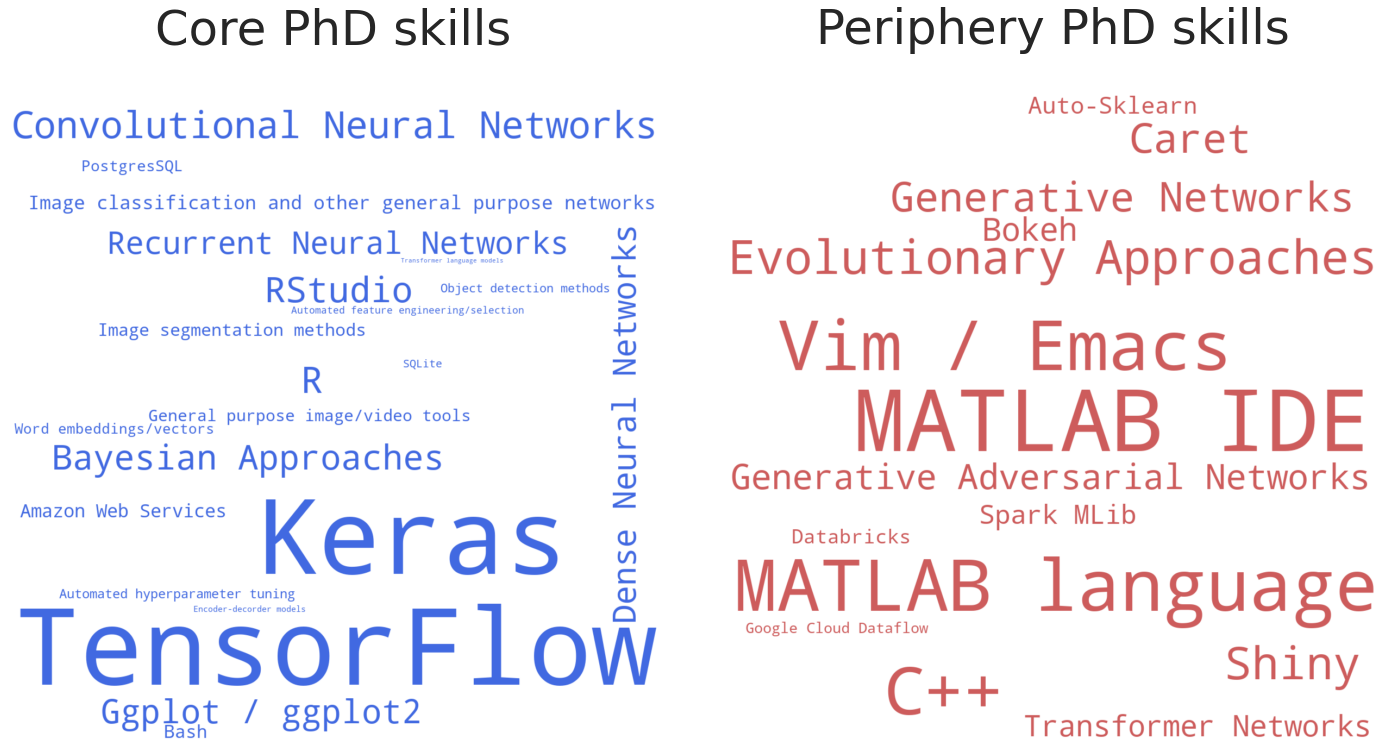

In [70]:
# Core PhD skills
core_phd_list = list(df_skills_stats.query("phd_bin == 1 and core_bin == 1").skill)
core_phd_list = df_fin.query("Q4 == 'Doctoral degree'").loc[:,core_phd_list].sum()

# Perephiery PhD skills
perephiery_phd_list = list(df_skills_stats.query("phd_bin == 1 and core_bin == 0").skill)
perephiery_phd_list = df_fin.query("Q4 == 'Doctoral degree'").loc[:,perephiery_phd_list].sum()

fig = plt.figure()
fig.set_size_inches(20, 10)
colors_set = ['royalblue', 'indianred']
skills_list = [core_phd_list,
               perephiery_phd_list]
titles_list = ['Core PhD skills', 'Periphery PhD skills']

for i in range(2):
    
    # Generate string with proportional words 
    top_skills = skills_list[i].sort_values(ascending=False)
    top_skills = top_skills.rank()
    skills_string = []
    for skill_i in range(len(top_skills)):
        skills_string.extend([top_skills.index[skill_i]] * int(top_skills.values[skill_i]))
    
    ax = fig.add_subplot(1,2,i+1)
    word_could_dict=Counter(skills_string)
    # Create wordcloud object
    wordcloud = WordCloud(width = 1200, height = 1200, background_color="white",
                          color_func=lambda *args, **kwargs: colors_set[i], relative_scaling = 0.5).generate_from_frequencies(word_could_dict)
    
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')
    # Set title
    ax.set_title(titles_list[i], size=48, pad=50)
    
plt.tight_layout(pad=0)
plt.show()

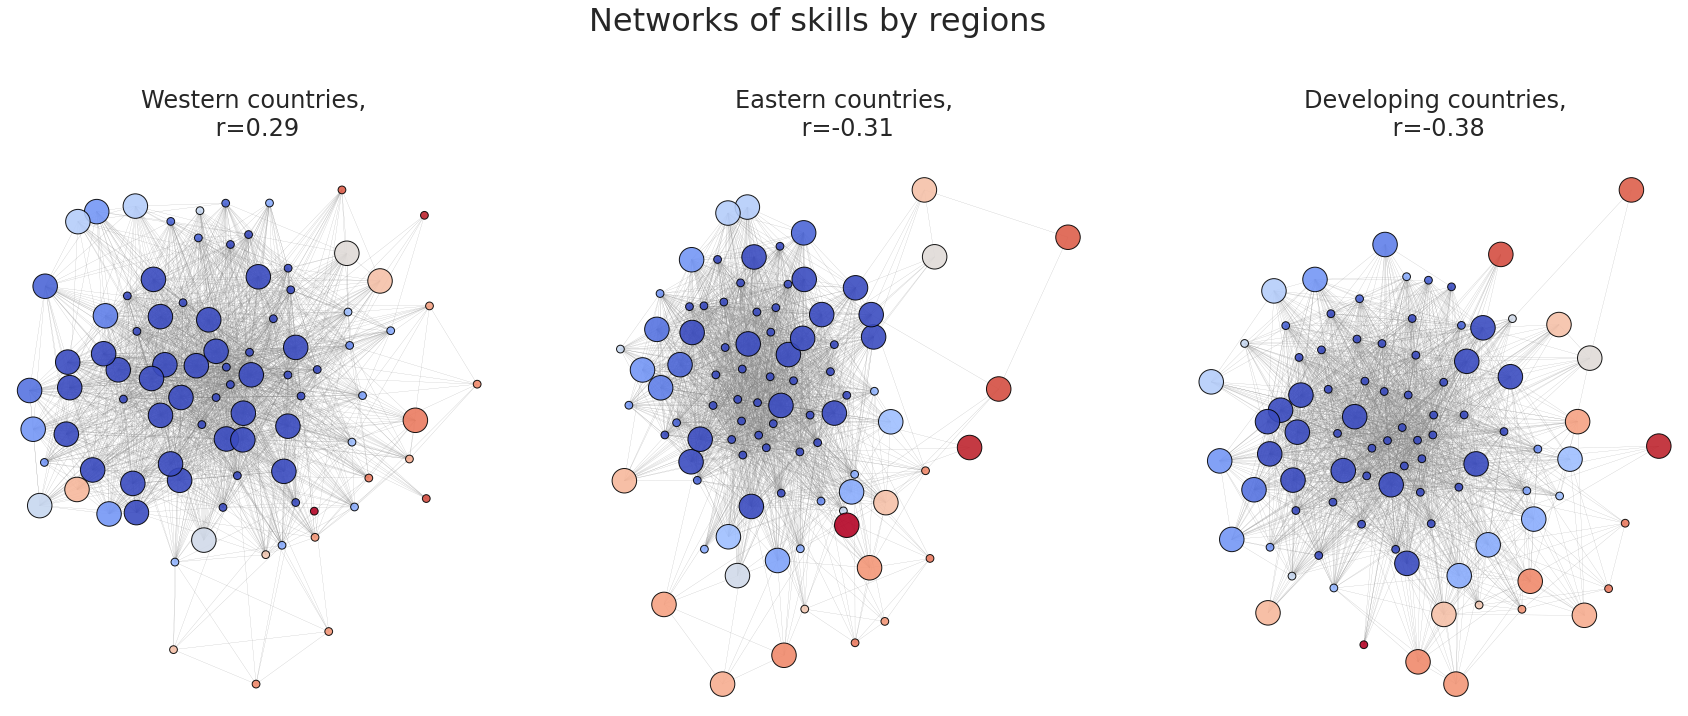

In [71]:
# Create grahs for each region
G_west, labels_west, df_skills_stats_west = createSkillsNetwork(df_fin, 'Western countries')
G_east, labels_east, df_skills_stats_east = createSkillsNetwork(df_fin, 'Eastern countries')
G_develop, labels_develop, df_skills_stats_develop = createSkillsNetwork(df_fin, 'Developing countries')

graphs = [G_west, G_east, G_develop]
df_skills_stats_list = [df_skills_stats_west, df_skills_stats_east, df_skills_stats_develop]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
ax = axes.flatten()
size_multip = 1

for i in range(3):
    # Create kamada-kawai layout
    pos_kkl = nx.kamada_kawai_layout(graphs[i])
    if i == 1:
        size_multip = 3
    # Draw network
    nx.draw_networkx(graphs[i], ax=ax[i], pos=pos_kkl,
                     node_size=list(map(lambda x: 600 if x >= df_skills_stats_list[i]['phd_proportion'].mean() else 60, list(df_skills_stats_list[i]['phd_proportion']))),
                     width=0.15,
                     edge_color='grey',node_color=list(df_skills_stats['core_number']), cmap="coolwarm_r", alpha=0.9,
                     with_labels=False)
    ax[i].set_axis_off()
    ax[i].collections[0].set_edgecolor("#000000")

# Set titles and correlation between coreness and PhD proportion
_ = axes[0].set_title('Western countries,\n r=0.29', fontsize=24, pad=30)
_ = axes[1].set_title('Eastern countries,\n r=-0.31', fontsize=24, pad=30)
_ = axes[2].set_title('Developing countries,\n r=-0.38', fontsize=24, pad=30)
# Set general title
st = fig.suptitle("Networks of skills by regions", fontsize=32, x =0.5, y=1.1)

plt.show()

In [0]:
# Remove students from the dataframe
df_fin = df_fin[df_fin['Q5'] != 'Student']

# # Drop respondents who did't indicate their salary
df_fin = df_fin.dropna(subset=['Q10'])

# Change salary from interval to numeric scale
def transformSalary(string):
    if string == "> $500,000":
        mean_salary = 750000.
    else:
        mean_salary = np.round(np.mean([np.float(string.split('-')[0].replace('$', '').replace(',', '')),
                                        np.float(string.split('-')[1].replace(',', ''))]))
    return mean_salary
df_fin['Q10'] = df_fin['Q10'].apply(transformSalary)
df_fin['Q10'] = df_fin['Q10'].astype('float')

# Add binary variable USA-not USA
df_fin['Q3_USA'] = ['USA' if country == 'USA' else 'not USA' for country in df_fin['Q3']]

# Recode experience
exp_order = ['< 1 years', '1-2 years', '3-5 years', '5-10 years', '10-20 years', '20+ years']
exp_level = ['Low experience', 'Low experience', 'Middle experience', 'Middle experience', 'High experience', 'High experience']
df_fin['Q15_level'] = df_fin['Q15'].map(dict(zip(exp_order, exp_level)))
df_fin['Q15_level'] = df_fin['Q15_level'].astype('category')
df_fin['Q15_level'].cat.reorder_categories(['Low experience', 'Middle experience', 'High experience'], inplace=True)

# Distribution of salary for PhD and distribution for Experience
df_fin_viz_phd_1 = df_fin.copy()
df_fin_viz_phd_1 = df_fin_viz_phd_1.query("Q4_phd != 'PhD'")

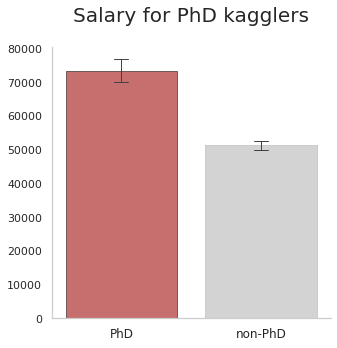

In [73]:
fig, ax = plt.subplots(figsize=(5, 5))
# First layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin, color=COLORS_SET_B_G_R[2],
                dodge=True, ci=90, capsize=0.1, errwidth =1, edgecolor='black')
# Second layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin_viz_phd_1, color='lightgrey',
                dodge=True, ci=None, capsize=0.1)

# Remove redundant labels and borders
sns.despine(left=False, bottom=False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.xaxis.set_label_text("")
ax.yaxis.set_label_text("")
# Set title
_ = ax.set_title('Salary for PhD kagglers', fontsize=20, pad=25)
# Set x ticks
ax.tick_params(axis='x', which='major', labelsize=12)
_ = ax.xaxis.set_ticklabels(["PhD", "non-PhD"])
_ = plt.setp(g.patches, linewidth=0.5) 

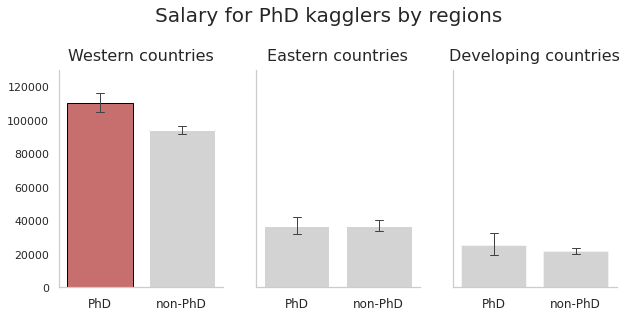

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
sns.set(font_scale=1, style="whitegrid")

# First layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin[df_fin['country_community'] == 'Western countries'], color=COLORS_SET_B_G_R[2],
                dodge=True, ci=90, capsize=0.1, ax=axes[0], errwidth =1, edgecolor='black')
# Second layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin_viz_phd_1[df_fin_viz_phd_1['country_community'] == 'Western countries'], color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[0])
# Set y lim
_ = axes[0].set_ylim((0, 130000))
# Remove redundant labels and borders
sns.despine(left=False, bottom=False)
axes[0].xaxis.grid(False)
axes[0].yaxis.grid(False)
axes[0].xaxis.set_label_text("")
axes[0].yaxis.set_label_text("")
# Set title
_ = axes[0].set_title('Western countries', fontsize=16, pad=10)
# Set x ticks params
axes[0].tick_params(axis='x', which='major', labelsize=12)
_ = axes[0].xaxis.set_ticklabels(["PhD", "non-PhD"])

g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin[df_fin['country_community'] == 'Eastern countries'], color='lightgrey',
                dodge=True, ci=90, capsize=0.1, ax=axes[1], errwidth =1)
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin_viz_phd_1[df_fin_viz_phd_1['country_community'] == 'Eastern countries'], color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[1])
# Set y limits
_ = axes[1].set_ylim((0, 130000))
# Remove redundant labels and borders
sns.despine(left=False, bottom=False)
axes[1].xaxis.grid(False)
axes[1].yaxis.grid(False)
axes[1].xaxis.set_label_text("")
axes[1].yaxis.set_label_text("")
# Set title
_ = axes[1].set_title('Eastern countries', fontsize=16, pad=10)
# Set x ticks
axes[1].tick_params(axis='x', which='major', labelsize=12)
axes[1].set_yticks([])
_ = axes[1].xaxis.set_ticklabels(["PhD", "non-PhD"])

# First layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin[df_fin['country_community'] == 'Developing countries'], color='lightgrey',
                dodge=True, ci=90, capsize=0.1, ax=axes[2], errwidth =1)
# Second layer
g = sns.barplot(x="Q4_phd", y="Q10",
                data=df_fin_viz_phd_1[df_fin_viz_phd_1['country_community'] == 'Developing countries'], color='lightgrey',
                dodge=True, ci=None, capsize=0.1, ax=axes[2])
# Set y lim
_ = axes[2].set_ylim((0, 130000))
# Remove redundant labels and borders
sns.despine(left=False, bottom=False)
axes[2].xaxis.grid(False)
axes[2].yaxis.grid(False)
axes[2].xaxis.set_label_text("")
axes[2].yaxis.set_label_text("")
_ = axes[2].set_title('Developing countries', fontsize=16, pad=10)
axes[2].tick_params(axis='x', which='major', labelsize=12)
axes[2].set_yticks([])
_ = axes[2].xaxis.set_ticklabels(["PhD", "non-PhD"])

# Additional options
fig.subplots_adjust(wspace=0.2)
plt.setp(g.patches, linewidth=0.5) 

# Set general title
st = fig.suptitle("Salary for PhD kagglers by regions", fontsize=20, x =0.5, y=1.1)


In [0]:
def salariesDifferencePhd(df, exp_level,  countries_community, q_threshold=0.95, SELECTED_SKILLS=SELECTED_SKILLS):
    '< 1 years', '1-2 years', '3-5 years', '5-10 years', '10-20 years', '20+ years'
    # Select subgroup of interest
    df = df.query("Q15_level == '{}' and country_community == '{}'".format(exp_level, countries_community))
        
    df.reset_index(inplace=True, drop=True)
    # Create similarity matrix
    similarity_matrix = cosine_similarity(df.loc[:,SELECTED_SKILLS])
    threshold = np.quantile(np.concatenate(similarity_matrix), q_threshold)
    similarity_matrix[similarity_matrix < threshold] = 0
    similarity_matrix[similarity_matrix >= threshold] = 1
    np.fill_diagonal(similarity_matrix, 0)
    # Create dictionaries with index number and PhD status/Salary
    dict_index_phd = dict(zip(df.index, df['Q4_phd']))
    dict_index_salary = dict(zip(df.index, df['Q10']))
    # Transform adjency matrix to edge list
    similarity_matrix = pd.DataFrame(similarity_matrix)
    similarity_matrix.values[[np.arange(len(similarity_matrix))]*2] = np.nan
    edge_list = similarity_matrix.stack().reset_index()
    # Select only edges with high similarity
    edge_list = edge_list[edge_list[0] == 1]
    edge_list = edge_list.drop(columns=0)
    # Label status of participants
    edge_list['level_0_phd'] = edge_list['level_0'].apply(lambda x: dict_index_phd[x], 1)
    edge_list['level_1_phd'] = edge_list['level_1'].apply(lambda x: dict_index_phd[x], 1)
    # Select only PhD/not-PhD pairs
    edge_list = edge_list[edge_list.loc[:,['level_0_phd', 'level_1_phd']].apply(lambda nodes: True if nodes[0] != nodes[1] else False, 1)]
    # Get salaries of participants
    edge_list['level_0_salary'] = edge_list['level_0'].apply(lambda x: dict_index_salary[x], 1)
    edge_list['level_1_salary'] = edge_list['level_1'].apply(lambda x: dict_index_salary[x], 1)
    edge_list = edge_list[edge_list['level_0_phd'] == 'PhD']
    # Calculate salaries difference
    salary_diff = edge_list.groupby('level_0')['level_0_salary'].mean() - edge_list.groupby('level_0')['level_1_salary'].mean()
    # Resulting dataframe
    result_df = pd.DataFrame({'Salary difference':salary_diff,
                'Experience level':len(salary_diff) * [exp_level],
                'Countries':len(salary_diff) * [countries_community]}).reset_index(drop=True)
    return result_df

# Calculate salary diff
salary_diff_df = pd.DataFrame()
for exp in ['Low experience', 'Middle experience', 'High experience']:
    for countries in ['Western countries', 'Eastern countries', 'Developing countries']:       
        salary_diff_df = salary_diff_df.append(salariesDifferencePhd(df_fin, exp, countries))
salary_diff_df.reset_index(inplace=True, drop=True)

# Order experience level for visualization
salary_diff_df['Experience level'] = salary_diff_df['Experience level'].astype('category')
salary_diff_df['Experience level'].cat.reorder_categories(['Low experience', 'Middle experience', 'High experience'], inplace=True)

# Create dataframes for visualization
salary_diff_df_viz_1 = salary_diff_df[salary_diff_df['Countries'] == 'Western countries'].copy()
salary_diff_df_viz_1 = salary_diff_df_viz_1[salary_diff_df_viz_1['Experience level'] != 'Low experience']

salary_diff_df_viz_2 = salary_diff_df[salary_diff_df['Countries'] == 'Eastern countries'].copy()
salary_diff_df_viz_2 = salary_diff_df_viz_2[salary_diff_df_viz_2['Experience level'] != 'Low experience']

salary_diff_df_viz_3 = salary_diff_df[salary_diff_df['Countries'] == 'Developing countries'].copy()
salary_diff_df_viz_3 = salary_diff_df_viz_3[salary_diff_df_viz_3['Experience level'] != 'High experience']

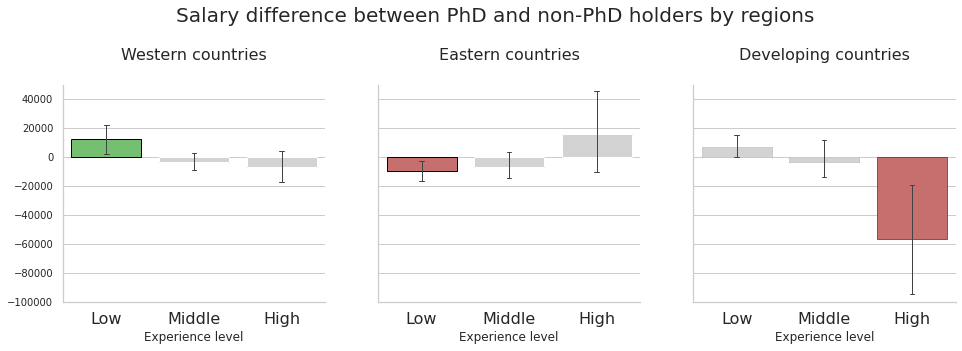

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
sns.set(font_scale=1, style="whitegrid")

### FIRST GRAPH
# Plot first layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df[salary_diff_df['Countries'] == 'Western countries'],
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[1], ax=axes[0], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df_viz_1,
                dodge=True, errwidth =2, ci=None, capsize=.05, color='lightgrey', ax=axes[0])
# Set y limit
_ = axes[0].set_ylim((-100000,50000))
# Remove redundant borderes
sns.despine(left=False, bottom=False)
axes[0].xaxis.grid(False)
axes[0].yaxis.set_label_text("")
# Set title
_ = axes[0].set_title('Western countries', fontsize=16, pad=25)
# Set x and y ticks
axes[0].tick_params(axis='y', which='major', labelsize=10)
axes[0].tick_params(axis='x', which='major', labelsize=16)
axes[0].xaxis.set_ticklabels(["Low", "Middle", "High"])

### SECOND GRAPH
# Plot first layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df[salary_diff_df['Countries'] == 'Eastern countries'],
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[2], ax=axes[1], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df_viz_2,
                dodge=True, errwidth =2, ci=None, capsize=.05, color='lightgrey', ax=axes[1])
# Set y limit
_ = axes[1].set_ylim((-100000,50000))
# Remove redundant borderes
sns.despine(left=False, bottom=False)
axes[1].xaxis.grid(False)
axes[1].yaxis.set_label_text("")
# Set title
_ = axes[1].set_title('Eastern countries', fontsize=16, pad=25)
# Set x and y ticks
axes[1].tick_params(axis='y', which='major', labelsize=10)
axes[1].tick_params(axis='x', which='major', labelsize=16)
axes[1].yaxis.set_ticklabels([])
axes[1].xaxis.set_ticklabels(["Low", "Middle", "High"])

### THIRD GRAPH
# Plot first layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df[salary_diff_df['Countries'] == 'Developing countries'],
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[2], ax=axes[2], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Experience level", y="Salary difference", data=salary_diff_df_viz_3,
                dodge=True, errwidth =2, ci=None, capsize=.05, color='lightgrey', ax=axes[2])
# Set y limit
_ = axes[2].set_ylim((-100000,50000))
# Remove redundant borderes
sns.despine(left=False, bottom=False)
axes[2].xaxis.grid(False)
axes[2].yaxis.set_label_text("")
# Set title
_ = axes[2].set_title('Developing countries', fontsize=16, pad=25)
# Set x and y ticks
axes[2].tick_params(axis='y', which='major', labelsize=10)
axes[2].tick_params(axis='x', which='major', labelsize=16)
_ = axes[2].yaxis.set_ticklabels([])
axes[2].xaxis.set_ticklabels(["Low", "Middle", "High"])

# Additional options
plt.setp(g.patches, linewidth=0.5)

# Set general title
st = fig.suptitle("Salary difference between PhD and non-PhD holders by regions", fontsize=20, x =0.5, y=1.15)

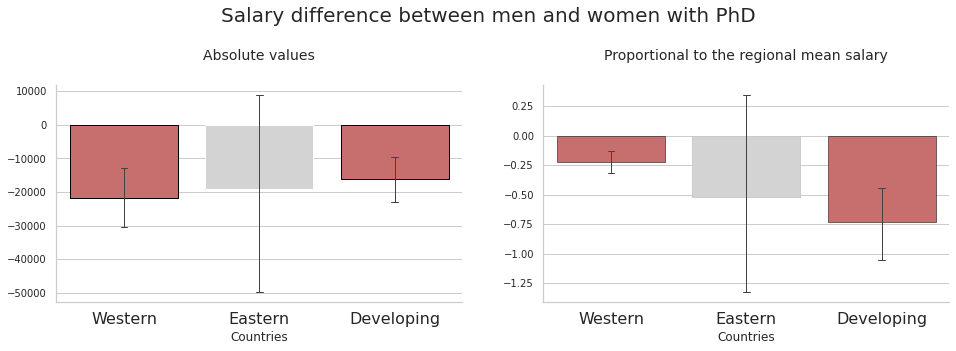

In [77]:
def salariesDifferenceGender(df, countries_community, q_threshold=0.95,
                             SELECTED_SKILLS=SELECTED_SKILLS, only_phd=True):
    
    # Select only male and female respondents
    df = df.query("Q2 == 'Male' or Q2 == 'Female'")
    
    # Select subgroup of interest
    df = df.query("country_community == '{}'".format(countries_community))
    
    if only_phd:
        df = df.query("Q4 == 'Doctoral degree'")
        
    df.reset_index(inplace=True, drop=True)
    # Create similarity matrix
    similarity_matrix = cosine_similarity(df.loc[:,SELECTED_SKILLS])
    threshold = np.quantile(np.concatenate(similarity_matrix), q_threshold)
    similarity_matrix[similarity_matrix < threshold] = 0
    similarity_matrix[similarity_matrix >= threshold] = 1
    np.fill_diagonal(similarity_matrix, 0)
    # Create dictionaries with index number and PhD status/Salary
    dict_index_phd = dict(zip(df.index, df['Q2']))
    dict_index_salary = dict(zip(df.index, df['Q10']))
    # Transform adjency matrix to edge list
    similarity_matrix = pd.DataFrame(similarity_matrix)
    similarity_matrix.values[[np.arange(len(similarity_matrix))]*2] = np.nan
    edge_list = similarity_matrix.stack().reset_index()
    # Select only edges with high similarity
    edge_list = edge_list[edge_list[0] == 1]
    edge_list = edge_list.drop(columns=0)
    # Label status of participants
    edge_list['level_0_phd'] = edge_list['level_0'].apply(lambda x: dict_index_phd[x], 1)
    edge_list['level_1_phd'] = edge_list['level_1'].apply(lambda x: dict_index_phd[x], 1)
    # Select only PhD/not-PhD pairs
    edge_list = edge_list[edge_list.loc[:,['level_0_phd', 'level_1_phd']].apply(lambda nodes: True if nodes[0] != nodes[1] else False, 1)]
    # Get salaries of participants
    edge_list['level_0_salary'] = edge_list['level_0'].apply(lambda x: dict_index_salary[x], 1)
    edge_list['level_1_salary'] = edge_list['level_1'].apply(lambda x: dict_index_salary[x], 1)
    edge_list = edge_list[edge_list['level_0_phd'] == 'Female']
    
    # Calculate salaries difference
    salary_diff = edge_list.groupby('level_0')['level_0_salary'].mean() - edge_list.groupby('level_0')['level_1_salary'].mean()

    # Resulting dataframe
    if only_phd:
        result_df = pd.DataFrame({'Salary difference':salary_diff,
                                  'Countries':len(salary_diff) * [countries_community],
                                  'Subset':len(salary_diff) * ['PhD']}).reset_index(drop=True)
    else:
        result_df = pd.DataFrame({'Salary difference':salary_diff,
                          'Countries':len(salary_diff) * [countries_community],
                          'Subset':len(salary_diff) * ['Total']}).reset_index(drop=True)
    
    return result_df

salary_diff_df_gender = pd.DataFrame()
for countries in ['Western countries', 'Eastern countries', 'Developing countries']:       
    salary_diff_df_gender = salary_diff_df_gender.append(salariesDifferenceGender(df_fin, countries, q_threshold=0.95))
salary_diff_df_gender.reset_index(inplace=True, drop=True)

# Take only PhD differences
salary_diff_df_gender_phd = salary_diff_df_gender[salary_diff_df_gender['Subset'] == 'PhD']

# Obtain mean salary for each region
dict_country_salary = {'Western countries':np.mean(df_fin[df_fin['country_community'] == 'Western countries']['Q10']),
                       'Eastern countries':np.mean(df_fin[df_fin['country_community'] == 'Eastern countries']['Q10']),
                       'Developing countries':np.mean(df_fin[df_fin['country_community'] == 'Developing countries']['Q10'])}
salary_diff_df_gender_phd['Mean salary'] = salary_diff_df_gender_phd['Countries'].map(dict_country_salary)
# Calculate proportional difference
salary_diff_df_gender_phd['Salary difference, proportional to the regional mean salary'] = salary_diff_df_gender_phd['Salary difference'] / salary_diff_df_gender_phd['Mean salary']

# Order countries for plot
salary_diff_df_gender_phd['Countries'] = salary_diff_df_gender_phd['Countries'].astype('category')
salary_diff_df_gender_phd['Countries'].cat.reorder_categories(["Western countries", "Eastern countries", "Developing countries"], inplace=True)

# Create dataframe for visualization
salary_diff_df_gender_phd_viz = salary_diff_df_gender_phd.copy()
salary_diff_df_gender_phd_viz = salary_diff_df_gender_phd_viz[salary_diff_df_gender_phd_viz['Countries'] == 'Eastern countries']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.set(font_scale=1, style="whitegrid")
# Plot first layer
g = sns.barplot(x="Countries", y="Salary difference", data=salary_diff_df_gender_phd,
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[2], ax=axes[0], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Countries", y="Salary difference", data=salary_diff_df_gender_phd_viz,
                dodge=True, errwidth =1, ci=None, capsize=.05, color='lightgrey', ax=axes[0])
# Remove redundant borders
sns.despine(left=False, bottom=False)
axes[0].xaxis.grid(False)
axes[0].yaxis.set_label_text("")
# Set title
_ = axes[0].set_title('Absolute values', fontsize=14, pad=25)
# Set ticks
axes[0].tick_params(axis='y', which='major', labelsize=10)
axes[0].tick_params(axis='x', which='major', labelsize=16)
_ = axes[0].xaxis.set_ticklabels(["Western", "Eastern", "Developing"])

# Plot first layer
g = sns.barplot(x="Countries", y="Salary difference, proportional to the regional mean salary", data=salary_diff_df_gender_phd,
                dodge=True, errwidth =1, ci=90, capsize=.05, color=COLORS_SET_B_G_R[2], ax=axes[1], edgecolor='black')
# Plot second layer
g = sns.barplot(x="Countries", y="Salary difference, proportional to the regional mean salary", data=salary_diff_df_gender_phd_viz,
                dodge=True, errwidth =1, ci=None, capsize=.05, color='lightgrey', ax=axes[1])
# Remove redundant borders
sns.despine(left=False, bottom=False)
axes[1].xaxis.grid(False)
axes[1].yaxis.set_label_text("")
# Set title
_ = axes[1].set_title('Proportional to the regional mean salary', fontsize=14, pad=25)
# Set ticks
axes[1].tick_params(axis='y', which='major', labelsize=10)
axes[1].tick_params(axis='x', which='major', labelsize=16)
_ = axes[1].xaxis.set_ticklabels(["Western", "Eastern", "Developing"])

# Additional options
_ = plt.setp(g.patches, linewidth=0.5) 

# Set general title
st = fig.suptitle('Salary difference between men and women with PhD', fontsize=20, x =0.5, y=1.15)